In [1]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../lrge_per_read_estimates.csv", low_memory=False)
df

,accession,method,estimate
0,SRR26337672,ava,1.079573e+07
1,SRR26337672,ava,1.144846e+07
2,SRR26337672,ava,1.034252e+07
3,SRR26337672,ava,1.127571e+07
4,SRR26337672,ava,9.544621e+06
...,...,...,...
95916014,DRR287515,2set,5.124770e+06
95916015,DRR287515,2set,3.641816e+06
95916016,DRR287515,2set,4.148180e+06
95916017,DRR287515,2set,2.859545e+06


In [3]:
samples = pd.read_csv("../results/estimates/estimates.tsv", sep="\t")
true_sizes = dict()
for _, row in samples.iterrows():
    true_sizes[row["run"]] = row["true_size"]

In [4]:
df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)

In [16]:
groups = df.groupby(["accession", "method"])

In [17]:
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f(group):
    relsizes = group["relative_size"]
    median = relsizes.median()
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(relsizes, np.arange(10, 90, 1.0))
    finite_percentiles = np.percentile(finite, np.arange(10, 90, 1.0))
    return pd.Series([median, finite_median] + list(percentiles) + list(finite_percentiles))

In [18]:
medians_df = groups.apply(f)

/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/s

In [19]:
medians_df.columns = ["median", "finite_median"] + [f"percentile_{i}" for i in np.arange(10, 90, 1.0)] + [f"finite_percentile_{i}" for i in np.arange(10, 90, 1.0)]
medians_df.to_csv("medians.csv")

In [20]:
medians_df = pd.read_csv("medians.csv", index_col=["accession", "method"])
medians_df

median  finite_median  percentile_10.0  percentile_11.0  \
accession  method                                                              
DRR072240  2set    2.205953       2.114013         1.278246         1.302491   
           ava     2.057436       2.057436         1.323000         1.346800   
DRR126367  2set    4.603692       4.234734         2.271170         2.338168   
           ava     4.196325       4.196325         2.500313         2.553213   
DRR126418  2set    3.996836       3.553474         1.484475         1.535290   
...                     ...            ...              ...              ...   
SRR9970116 ava     1.016976       1.016976         0.703047         0.720746   
SRR9970117 2set    1.014124       1.009299         0.744776         0.758519   
           ava     1.031338       1.031338         0.786287         0.796965   
SRR9988395 2set    2.916679       1.443319         0.976161         1.002022   
           ava     1.448346       1.448346         0.904083         0.924937   

                   percentile_12.0  percentile_13.0  percentile_14.0  \
accession  method                                                      
DRR072240  2set           1.329465         1.357630         1.379654   
           ava            1.367289         1.388559         1.407912   
DRR126367  2set           2.399694         2.456960         2.521139   
           ava            2.606431         2.651984         2.695253   
DRR126418  2set           1.579669         1.639888         1.685789   
...                            ...              ...              ...   
SRR9970116 ava            0.737246         0.750978         0.762774   
SRR9970117 2set           0.769830         0.779516         0.787646   
           ava            0.808101         0.818985         0.828314   
SRR9988395 2set           1.022736         1.049989         1.072995   
           ava            0.943098         0.959225         0.975951   

                   percentile_15.0  percentile_16.0  percentile_17.0  ...  \
accession  method                                                     ...   
DRR072240  2set           1.398926         1.423790         1.447668  ...   
           ava            1.425298         1.445897         1.464165  ...   
DRR126367  2set           2.577282         2.627263         2.684019  ...   
           ava            2.744896         2.788883         2.832588  ...   
DRR126418  2set           1.725127         1.776328         1.819736  ...   
...                            ...              ...              ...  ...   
SRR9970116 ava            0.772585         0.782860         0.791001  ...   
SRR9970117 2set           0.796976         0.806280         0.814403  ...   
           ava            0.838100         0.846343         0.854493  ...   
SRR9988395 2set           1.102154         1.136976         1.161990  ...   
           ava            0.992121         1.007850         1.022355  ...   

                   finite_percentile_80.0  finite_percentile_81.0  \
accession  method                                                   
DRR072240  2set                  3.629827                3.724939   
           ava                   3.530640                3.663467   
DRR126367  2set                  9.767207               10.444192   
           ava                  12.456885               13.544207   
DRR126418  2set                  9.881056               10.449499   
...                                   ...                     ...   
SRR9970116 ava                   1.263445                1.274232   
SRR9970117 2set                  1.255206                1.271263   
           ava                   1.229547                1.238147   
SRR9988395 2set                  2.154315                2.191387   
           ava                   2.023782                2.055006   

                   finite_percentile_82.0  finite_percentile_83.0  \
accession  method                                                   
DRR07

In [10]:
# melt data so that finite and all medians are in the same column with a column indicating which one it is
melted = medians_df.reset_index().melt(id_vars=["accession", "method"], value_vars=["median", "finite_median"], var_name="type", value_name="value")

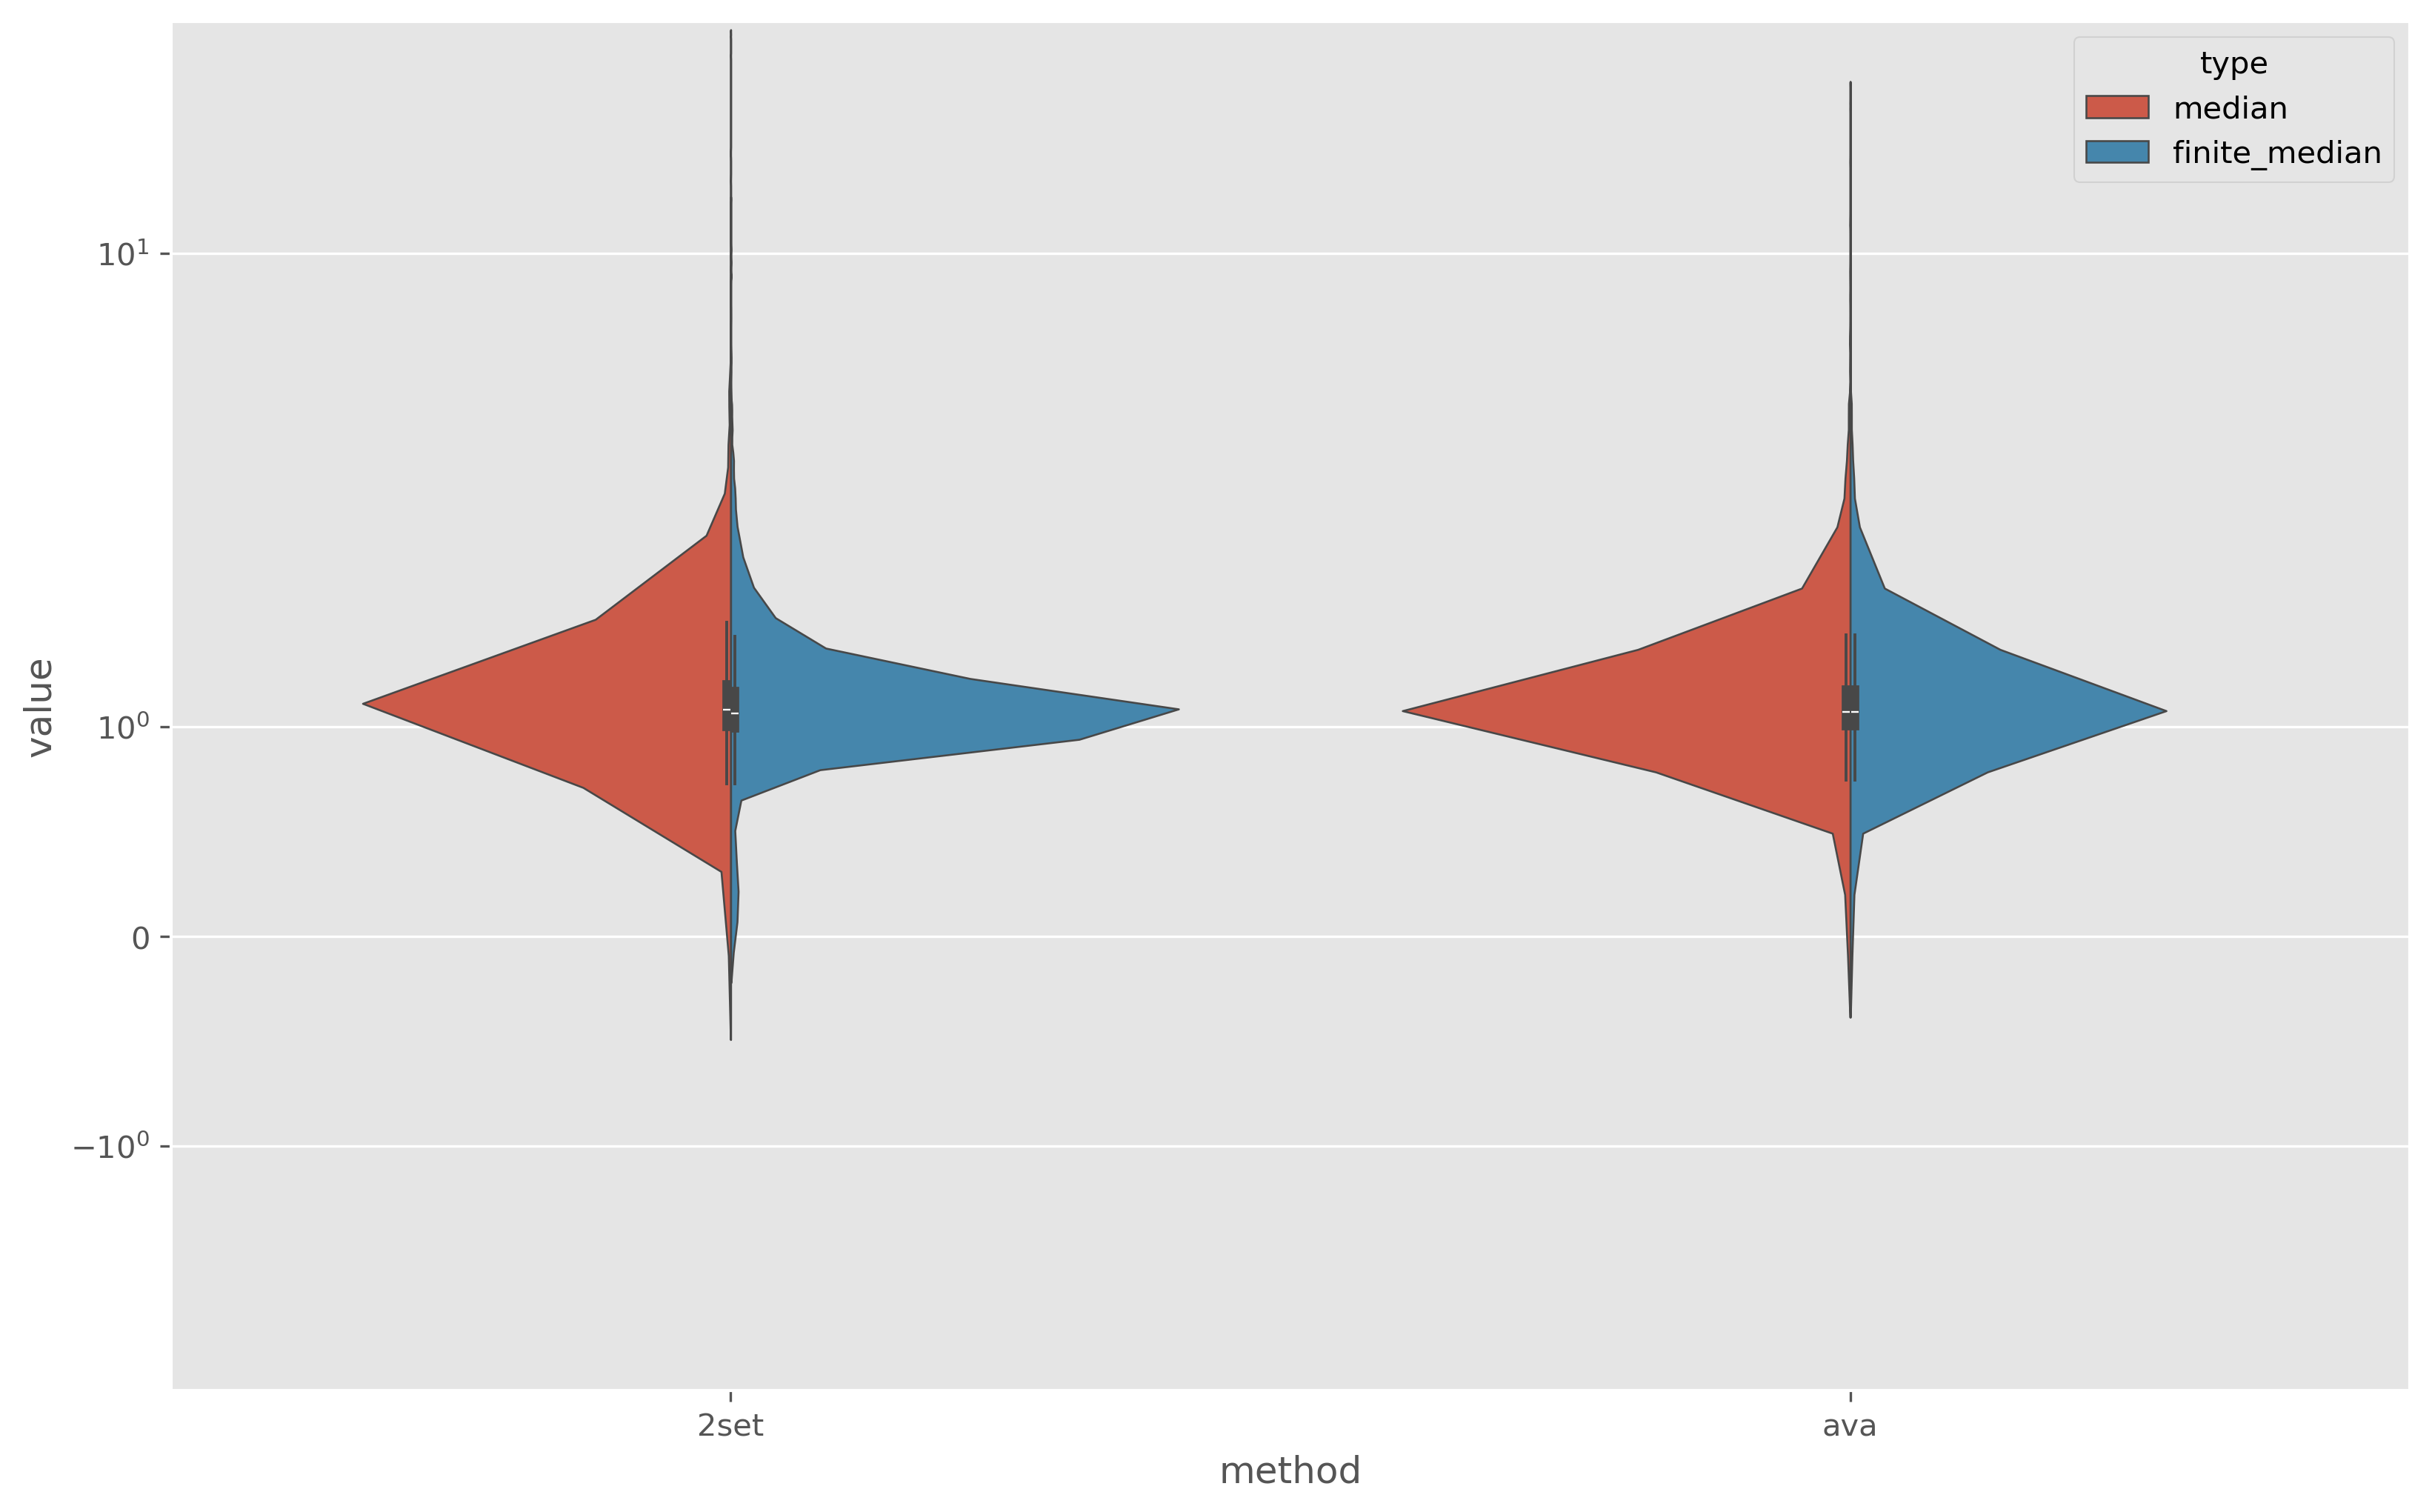

In [17]:
fig, ax = plt.subplots(dpi=300)

# sns.boxenplot(data=melted, x="method", y="value", hue="type", ax=ax)
sns.violinplot(data=melted, x="method", y="value", hue="type", ax=ax, split=True)
ax.set_yscale("symlog")

In [16]:
melted.groupby(["method", "type"]).describe()

/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


value                                          \
                       count      mean       std       min       25%   
method type                                                            
2set   finite_median  3465.0  1.155490  0.568976  0.002234  0.993529   
       median         3465.0       inf       NaN  0.002234  1.004253   
ava    finite_median  3465.0  1.209259  1.012929  0.011601  1.005271   
       median         3465.0  1.209259  1.012929  0.011601  1.005271   

                                                     
                           50%       75%        max  
method type                                          
2set   finite_median  1.062897  1.169746  13.920254  
       median         1.085356  1.220623        inf  
ava    finite_median  1.070860  1.178180  28.164442  
       median         1.070860  1.178180  28.164442

In [12]:
# show where medians are different
medians_df[medians_df["median"] != medians_df["finite_median"]]

,,median,finite_median,percentile_2.5,percentile_5.0,percentile_7.5,percentile_10.0,percentile_12.5,percentile_15.0,percentile_17.5,percentile_20.0,...,finite_percentile_75.0,finite_percentile_77.5,finite_percentile_80.0,finite_percentile_82.5,finite_percentile_85.0,finite_percentile_87.5,finite_percentile_90.0,finite_percentile_92.5,finite_percentile_95.0,finite_percentile_97.5
accession,method,,,,,,,,,,,,,,,,,,,,,
DRR072240,2set,2.205953,2.114013,0.950543,1.088166,1.187026,1.278246,1.348108,1.398926,1.460134,1.509590,...,3.161112,3.378205,3.629827,3.929384,4.282197,4.790821,5.679067,7.072960,10.296089,18.895478
DRR126367,2set,4.603692,4.234734,1.490992,1.852709,2.093078,2.271170,2.428232,2.577282,2.712279,2.842827,...,7.553057,8.530753,9.767207,11.356116,13.486681,16.423281,20.029623,23.651747,30.410502,39.640542
DRR126418,2set,3.996836,3.553474,0.801433,1.078254,1.325569,1.484475,1.608479,1.725127,1.841515,1.961439,...,7.858825,8.647565,9.881056,11.143004,12.797672,14.773303,18.013552,22.662734,27.379001,35.115639
DRR126420,2set,4.118922,3.817887,0.936286,1.329816,1.566461,1.719402,1.851204,1.978698,2.100755,2.236339,...,6.284926,6.795098,7.414811,8.190184,9.104439,10.960639,12.889729,16.360204,23.057184,30.838410
DRR140496,2set,1.853989,1.698482,0.446683,0.636323,0.844200,0.981288,1.066993,1.139565,1.197493,1.249091,...,2.374262,2.505015,2.688774,2.865905,3.157563,3.503286,3.986727,4.706029,6.242208,11.111024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9900640,2set,1.700330,1.465656,0.557416,0.684710,0.767150,0.834180,0.892937,0.934093,0.988293,1.039868,...,2.137918,2.300387,2.499247,2.916751,3.356690,3.458015,3.577416,3.757529,4.057467,4.660531
SRR9901958,2set,1.316152,1.259790,0.337257,0.473974,0.549280,0.622813,0.687344,0.749841,0.811766,0.861338,...,1.716464,1.798801,1.932481,2.000018,2.130370,2.448517,2.616629,3.325420,4.894798,9.678567
SRR9970116,2set,1.012217,1.006146,0.222938,0.352214,0.460456,0.594210,0.664197,0.705026,0.743646,0.775313,...,1.212310,1.239191,1.271971,1.304227,1.349336,1.402790,1.469200,1.563263,1.722884,2.006931


In [21]:
data = []
percentile_bins = [5, 10, 20, 30, 40, 50]
for percentile in percentile_bins:
    low_percentile = float(50 - percentile * 0.6)
    high_percentile = float(50 + percentile * 0.4)
    for (acc, method), row in medians_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        low_finite_val = row[f"finite_percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        high_finite_val = row[f"finite_percentile_{high_percentile}"]
        all_contains_one = low_val <= 1.0 <= high_val
        finite_contains_one = low_finite_val <= 1.0 <= high_finite_val
        gsize = true_sizes[acc]
        data.append([acc, method, percentile, low_percentile, high_percentile, 'all', low_val, high_val, all_contains_one, gsize])
        data.append([acc, method, percentile, low_percentile, high_percentile, 'finite', low_finite_val, high_finite_val, finite_contains_one, gsize])


In [22]:
percentile_df = pd.DataFrame(data, columns=["accession", "method", "percentile_bin", "low_percentile", "high_percentile", "type", "low", "high", "contains_one", "true_size"])
percentile_df

,accession,method,percentile_bin,low_percentile,high_percentile,type,low,high,contains_one,true_size
0,DRR072240,2set,5,47.0,52.0,all,2.120813,2.255261,False,2877864
1,DRR072240,2set,5,47.0,52.0,finite,2.038156,2.160050,False,2877864
2,DRR072240,ava,5,47.0,52.0,all,1.988994,2.105785,False,2877864
3,DRR072240,ava,5,47.0,52.0,finite,1.988994,2.105785,False,2877864
4,DRR126367,2set,5,47.0,52.0,all,4.352304,4.761218,False,3320462
...,...,...,...,...,...,...,...,...,...,...
83155,SRR9970117,ava,50,20.0,70.0,finite,0.875416,1.152386,True,4891702
83156,SRR9988395,2set,50,20.0,70.0,all,1.242292,NaN,False,6835731
83157,SRR9988395,2set,50,20.0,70.0,finite,1.002615,1.834330,False,6835731
83158,SRR9988395,ava,50,20.0,70.0,all,1.064224,1.769909,False,6835731


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_94348/1000224015.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


[Text(0, 0, '47-52'),
 Text(1, 0, '44-54'),
 Text(2, 0, '38-58'),
 Text(3, 0, '32-62'),
 Text(4, 0, '26-66'),
 Text(5, 0, '20-70')]

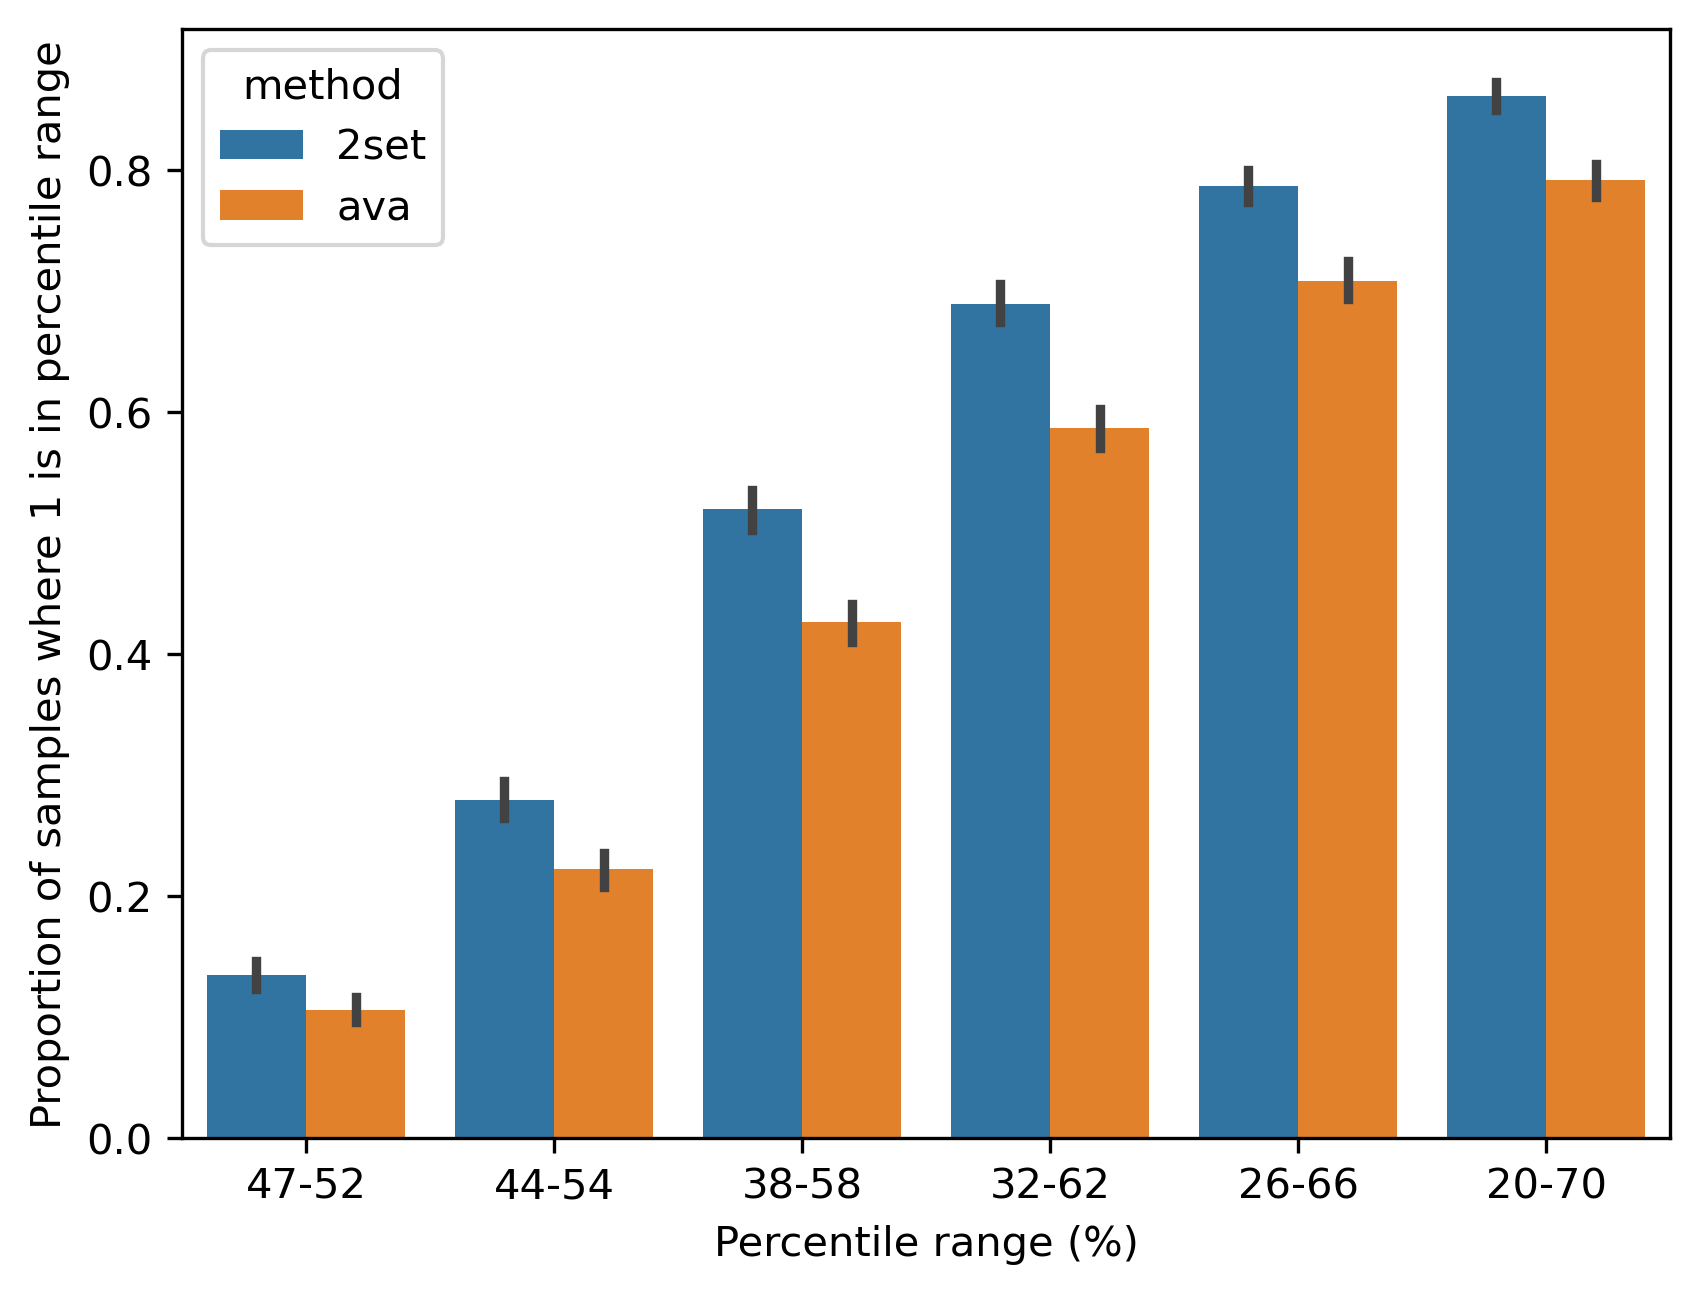

In [23]:
# on the xaxis, we plot the percentile bins, on the yaxis we plot the proportion of samples with True in the contains_one column
# and we hue on the method
d = percentile_df.query("type == 'finite'")
fig, ax = plt.subplots(dpi=300)
sns.barplot(data=d, x="percentile_bin", y="contains_one", hue="method", ax=ax)
ax.set_ylabel("Proportion of samples where 1 is in percentile range")
ax.set_xlabel("Percentile range (%)")
xticks = percentile_bins
xticklabels = [f"{50 - p * 0.6:g}-{50 + p * 0.4:g}" for p in percentile_bins]
# ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

In [24]:
# plot where each genome is a dot, the x axis is genome size and the y axis is |IQR|/GS
percentile_df["iqr"] = percentile_df["high"] - percentile_df["low"]
percentile_df["|IQR|/GS"] = percentile_df["iqr"] / percentile_df["true_size"]

/Users/michael/sw/miniforge3/envs/lrge/lib/python3.13/site-packages/seaborn/relational.py:733: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


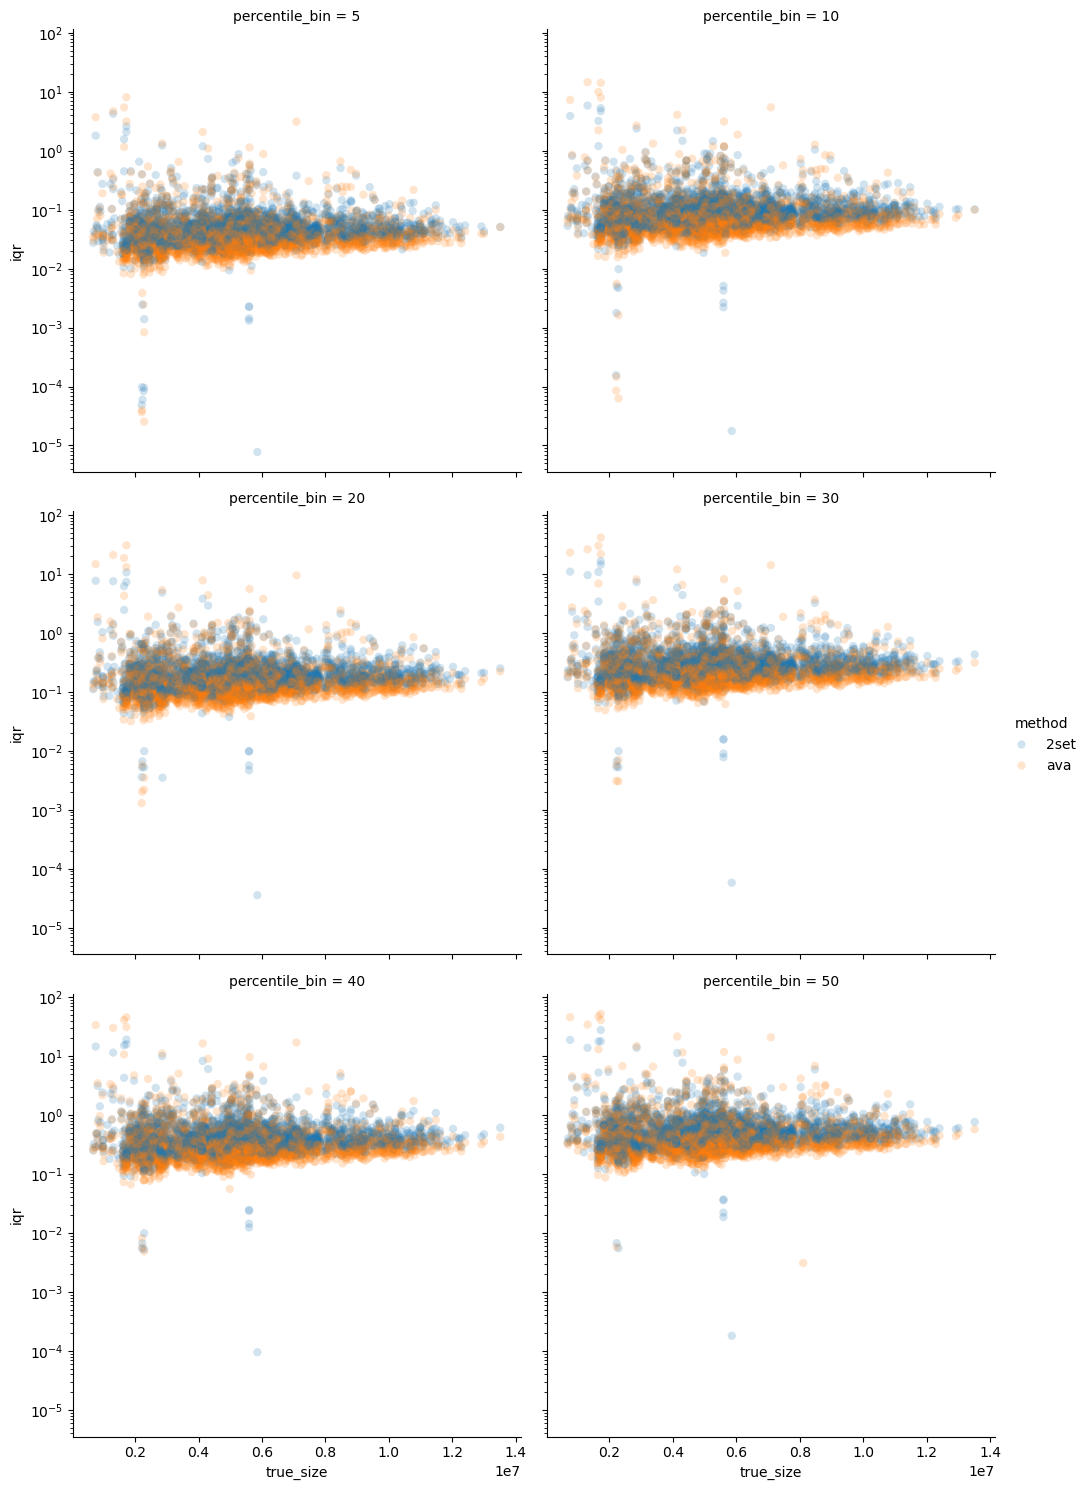

In [25]:
# fig, ax = plt.subplots(dpi=300)
d = percentile_df.query("type == 'finite'")
g = sns.relplot(
    data=d,
    x="true_size",
    y="iqr",
    hue="method",
    col="percentile_bin",
    ax=ax,
    col_wrap=2,
    linewidth=0,
    alpha=0.2,
)
g.set(yscale="log")

In [26]:
print(d.groupby(["method", "percentile_bin"])[["iqr"]].describe().to_csv())

,,iqr,iqr,iqr,iqr,iqr,iqr,iqr,iqr
,,count,mean,std,min,25%,50%,75%,max
method,percentile_bin,,,,,,,,
2set,5,3465.0,0.05715272211775541,0.11382201744875253,0.0,0.0327128906737737,0.042125427255850445,0.056160171236915746,4.2306916362816
2set,10,3465.0,0.1132739348581285,0.2044941876603279,0.0,0.06611714575146332,0.08482555241961665,0.11192441860228053,5.828384708486274
2set,20,3465.0,0.22505802760098625,0.3602697496230581,0.0,0.13319220590781045,0.17115485362442606,0.22546993082564604,10.640634408061583
2set,30,3465.0,0.3446230481518517,0.5612251078687315,0.0,0.2029506464644365,0.26008330953033454,0.344065025975833,16.490927959430635
2set,40,3465.0,0.470578291858558,0.7072850015631196,0.0,0.28024664114625286,0.3563990542818971,0.47353870945639953,19.09558188700986
2set,50,3465.0,0.6148070098638482,0.9126212563427519,0.0,0.3676930923630425,0.4682732675679746,0.6212027186471013,27.731875830254232
ava,5,3465.0,0.05394121396981204,0.21851709597060906,0.0,0.025051619921247825,0.0327173349932

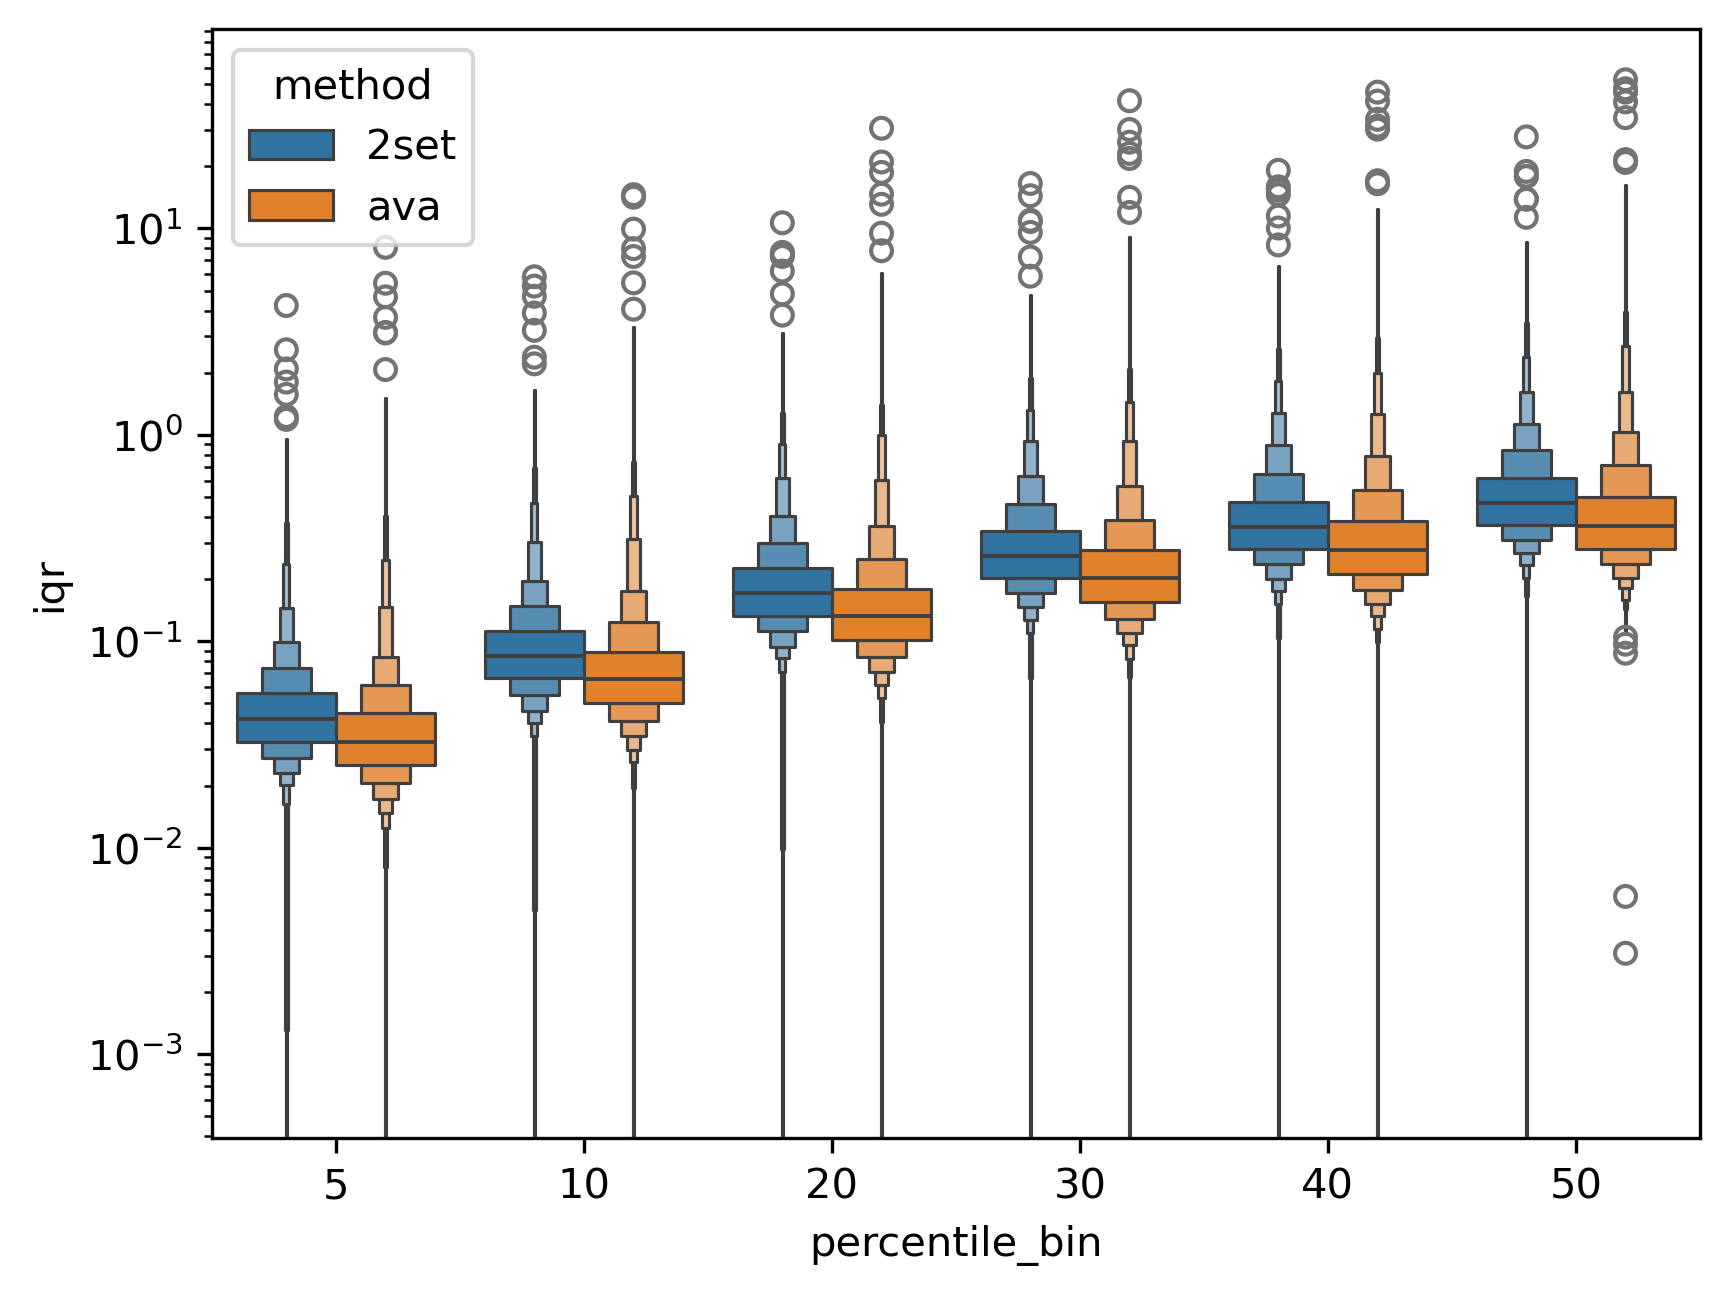

In [27]:
fig, ax = plt.subplots(dpi=300)
sns.boxenplot(data=d, x="percentile_bin", y="iqr", hue="method", ax=ax)
ax.set_yscale("log")

In [28]:
# make a table grouped by method and percentile bin with the proportion of samples that 
# have a value of True for contains_one and the mean IQR
# print(percentile_df.groupby(["method", "percentile_bin"])["contains_one"].mean().unstack().to_csv())
iqr_summary = percentile_df.groupby(["method", "percentile_bin"])[["contains_one", "iqr"]].mean().sort_values("percentile_bin")
print(iqr_summary.to_csv())

method,percentile_bin,contains_one,iqr
2set,5,0.1266955266955267,0.06906819050035642
ava,5,0.10591630591630592,0.05394121396981204
2set,10,0.2619047619047619,0.14038228860250557
ava,10,0.2222222222222222,0.10937712004153367
2set,20,0.5,0.2734495266790217
ava,20,0.42655122655122657,0.21570021589970872
2set,30,0.6718614718614718,0.39490890591089994
ava,30,0.5873015873015873,0.3278708518913737
2set,40,0.7744588744588745,0.552377061267803
ava,40,0.7085137085137085,0.44762902643174673
2set,50,0.8490620490620491,0.7029224893274298
ava,50,0.7919191919191919,0.5834444345345108



<Axes: xlabel='iqr', ylabel='contains_one'>

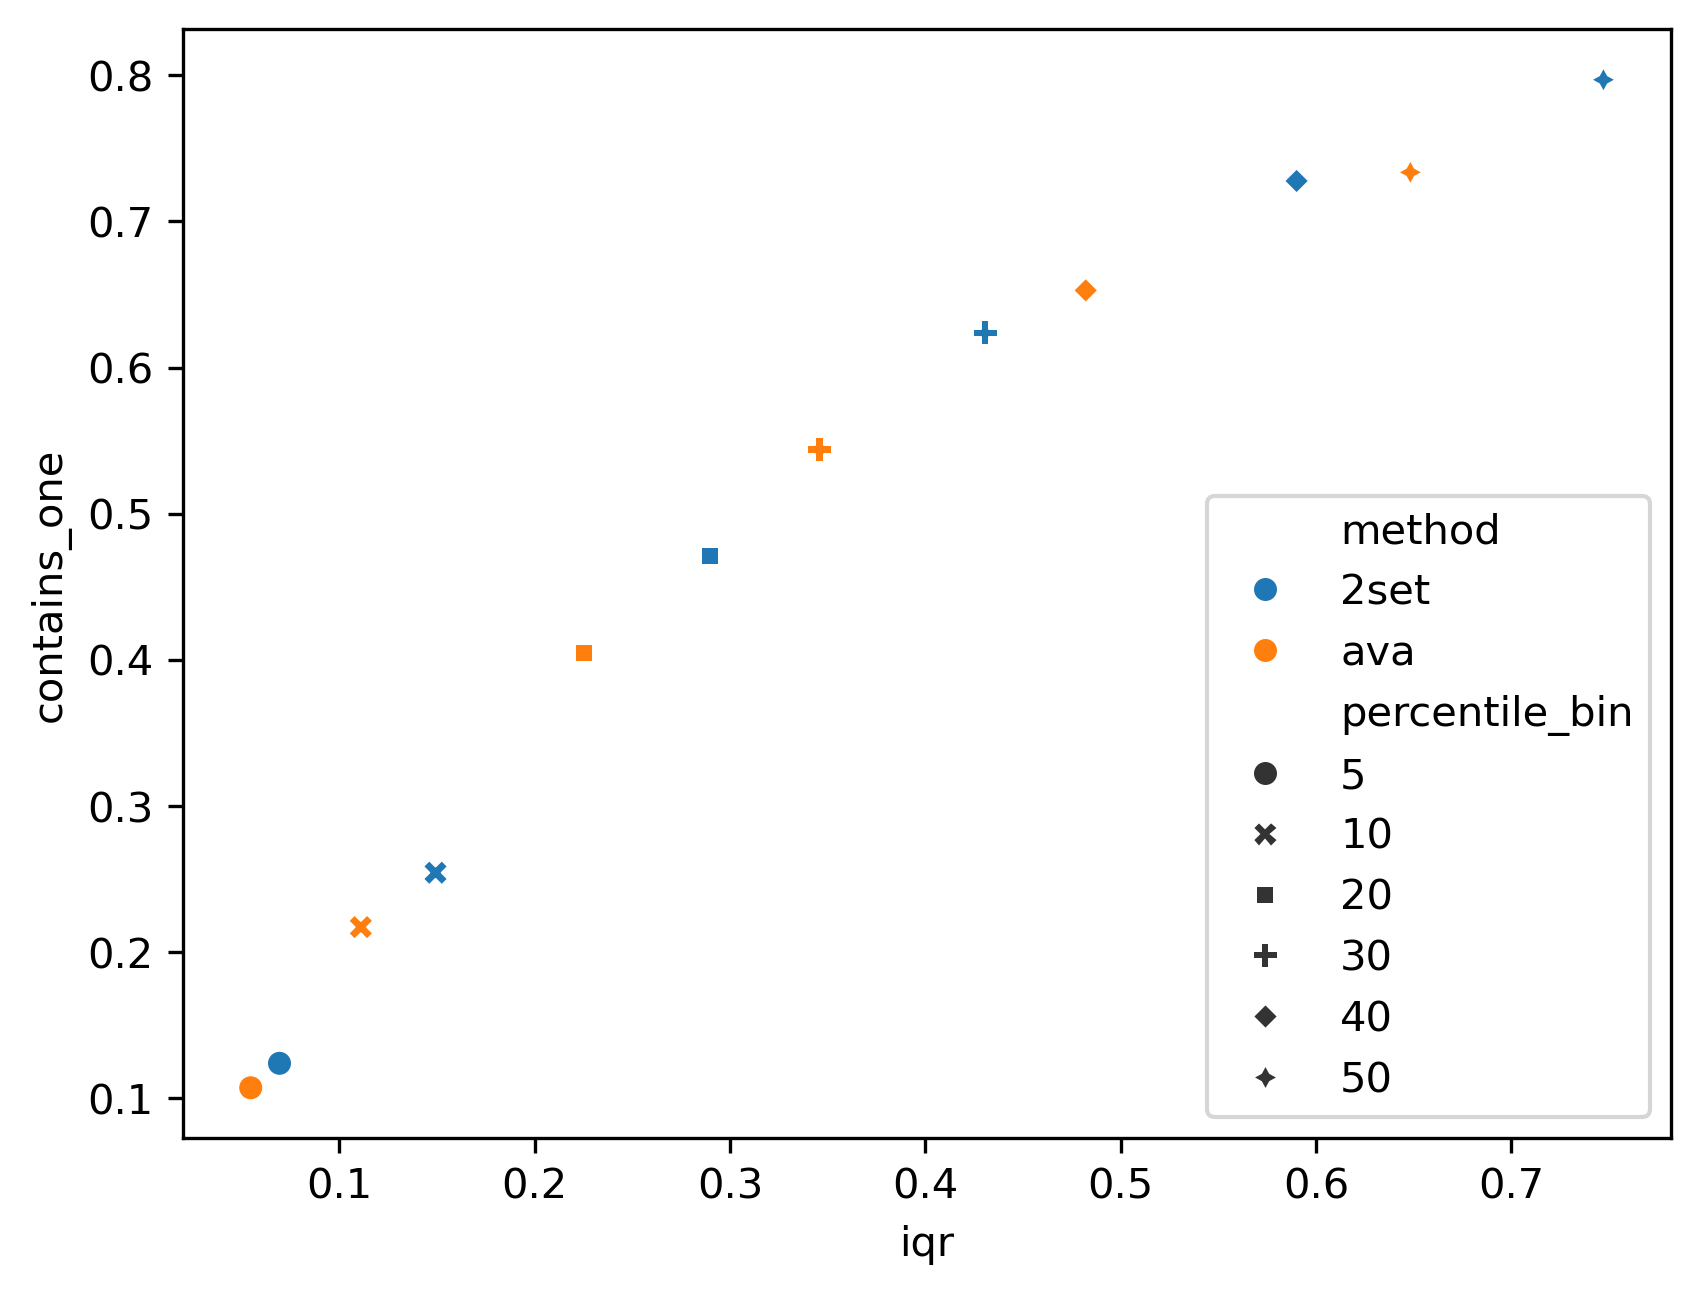

In [49]:
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(data=iqr_summary, x="iqr", y="contains_one", hue="method", ax=ax, style="percentile_bin")

Text(0, 0.5, 'Proportion of samples where 1 is in percentile range')

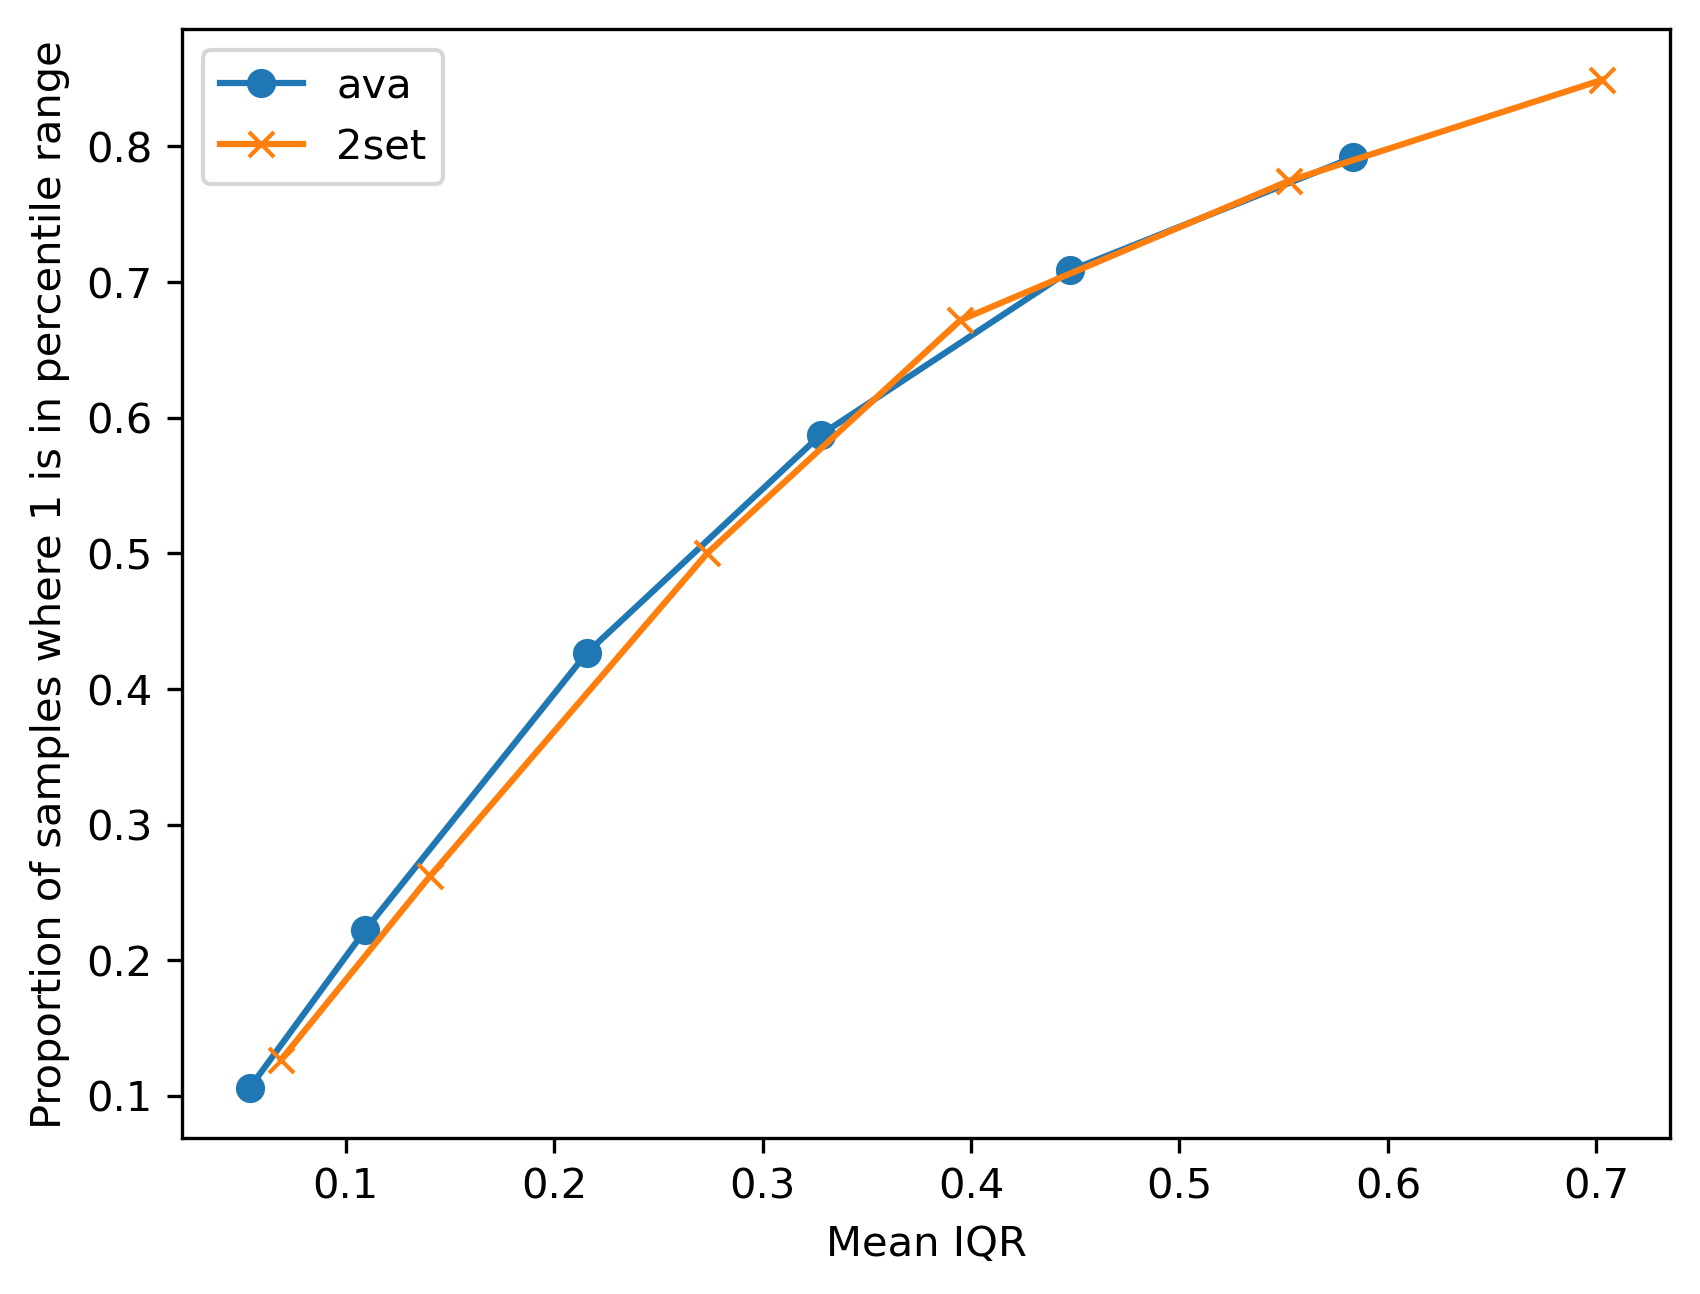

In [29]:
fig, ax = plt.subplots(dpi=300)
ax.plot("iqr", "contains_one", data=iqr_summary.query("method == 'ava'"), marker="o")
ax.plot("iqr", "contains_one", data=iqr_summary.query("method == '2set'"), marker="x")
ax.legend(["ava", "2set"])
ax.set_xlabel("Mean IQR")
ax.set_ylabel("Proportion of samples where 1 is in percentile range")

We could potentially investigate this using a sliding window of 50% ranges going from [1,51], ...[49,99]     - I realise a bit of a pain to do

In [41]:

perc_range = np.arange(1, 100, 1.0)
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f2(group):
    relsizes = group["relative_size"]
    median = relsizes.median()
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(finite, perc_range)
    return pd.Series([finite_median] + list(percentiles))

In [42]:
range_df = groups.apply(f2)
range_df.columns = ["median"] + [f"percentile_{i}" for i in perc_range]

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_94348/3193635748.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  range_df = groups.apply(f2)


In [43]:
data = []
rng = 50
percentile_bins = list(range(1, 50))
for percentile in map(float, percentile_bins):
    low_percentile = percentile
    high_percentile = percentile + rng
    for (acc, method), row in range_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        contains_one = low_val <= 1.0 <= high_val
        gsize = true_sizes[acc]
        data.append([acc, method, percentile, low_percentile, high_percentile, low_val, high_val, contains_one, gsize])

In [44]:
rng_scan = pd.DataFrame(data, columns=["accession", "method", "percentile_bin", "low_percentile", "high_percentile", "low", "high", "contains_one", "true_size"])

In [46]:
rng_scan["IQR"] = rng_scan["high"] - rng_scan["low"]
rng_scan

,accession,method,percentile_bin,low_percentile,high_percentile,low,high,contains_one,true_size,IQR
0,DRR072240,2set,1.0,1.0,51.0,0.472986,2.132691,True,2877864,1.659706
1,DRR072240,ava,1.0,1.0,51.0,0.771945,2.080740,True,2877864,1.308795
2,DRR126367,2set,1.0,1.0,51.0,0.935313,4.327670,True,3320462,3.392358
3,DRR126367,ava,1.0,1.0,51.0,1.636723,4.249117,False,3320462,2.612394
4,DRR126418,2set,1.0,1.0,51.0,0.594682,3.655987,True,3138474,3.061304
...,...,...,...,...,...,...,...,...,...,...
339565,SRR9970116,ava,49.0,49.0,99.0,1.009894,3.283948,False,4028093,2.274053
339566,SRR9970117,2set,49.0,49.0,99.0,1.002950,2.618104,False,4891702,1.615154
339567,SRR9970117,ava,49.0,49.0,99.0,1.025388,2.572403,False,4891702,1.547015
339568,SRR9988395,2set,49.0,49.0,99.0,1.429845,6.504171,False,6835731,5.074326


Text(0, 0.5, 'Proportion of samples where 1 is in percentile range')

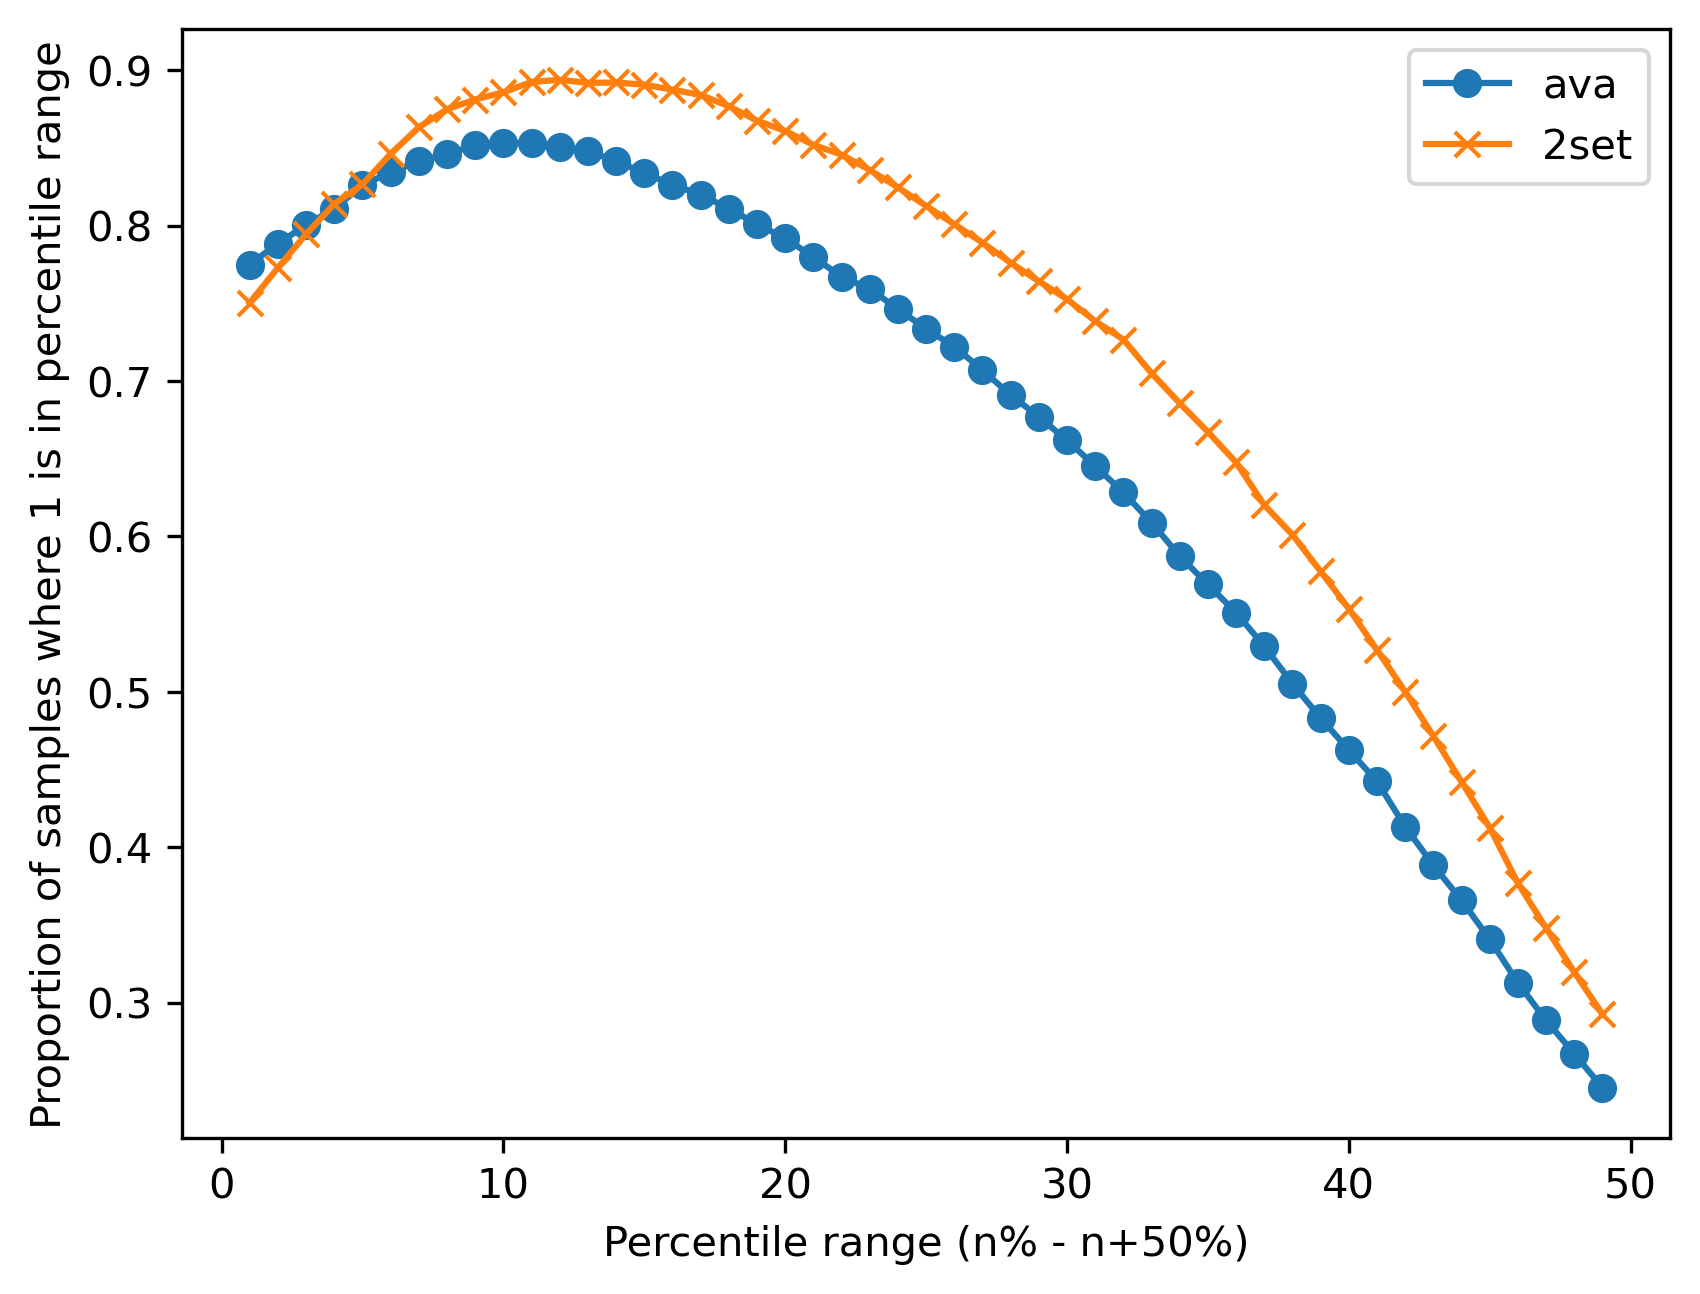

In [60]:
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["method", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()
ax.plot("percentile_bin", "contains_one", data=d.query("method == 'ava'"), marker="o")
ax.plot("percentile_bin", "contains_one", data=d.query("method == '2set'"), marker="x")
ax.legend(["ava", "2set"])
ax.set_xlabel("Percentile range (n% - n+50%)")
ax.set_ylabel("Proportion of samples where 1 is in percentile range")

In [68]:
# get the maximum IQR and contains_one for each method
max_ix = d.groupby("method")["contains_one"].idxmax()
print(d.loc[max_ix].to_markdown(index=False))

| method   |   percentile_bin |   contains_one |      IQR |
|:---------|-----------------:|---------------:|---------:|
| 2set     |               12 |       0.893795 | 0.603704 |
| ava      |               11 |       0.853391 | 0.56274  |


In [69]:
min_ix = d.groupby("method")["IQR"].idxmin()
print(d.loc[min_ix].to_markdown(index=False))

| method   |   percentile_bin |   contains_one |      IQR |
|:---------|-----------------:|---------------:|---------:|
| 2set     |               15 |       0.89062  | 0.596553 |
| ava      |               14 |       0.841558 | 0.55607  |


Exploring how query size impacts CI

In [2]:
df = pd.read_csv("lrge_2set_per_read_estimates.csv", low_memory=False)
df

,accession,Q,estimate
0,SRR19357516,500000,6.443648e+06
1,SRR19357516,500000,6.203436e+06
2,SRR19357516,500000,5.800353e+06
3,SRR19357516,500000,6.113187e+06
4,SRR19357516,500000,6.200029e+06
...,...,...,...
349995,SRR27033724,10000,4.593996e+06
349996,SRR27033724,10000,5.666436e+06
349997,SRR27033724,10000,4.895360e+06
349998,SRR27033724,10000,5.501997e+06


In [4]:
df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)

In [5]:
groups = df.groupby(["accession", "Q"])

In [6]:
perc_range = np.arange(1, 100, 1.0)
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f2(group):
    relsizes = group["relative_size"]
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(finite, perc_range)
    return pd.Series([finite_median] + list(percentiles))

In [7]:
range_df = groups.apply(f2)
range_df.columns = ["median"] + [f"percentile_{i}" for i in perc_range]

/tmp/ipykernel_460659/3193635748.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  range_df = groups.apply(f2)


In [8]:
data = []
rng = 50
percentile_bins = list(range(1, 50))
for percentile in map(float, percentile_bins):
    low_percentile = percentile
    high_percentile = percentile + rng
    for (acc, Q), row in range_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        contains_one = low_val <= 1.0 <= high_val
        gsize = true_sizes[acc]
        data.append([acc, Q, percentile, low_percentile, high_percentile, low_val, high_val, contains_one, gsize])

In [9]:
rng_scan = pd.DataFrame(data, columns=["accession", "Q", "percentile_bin", "low_percentile", "high_percentile", "low", "high", "contains_one", "true_size"])

In [10]:
rng_scan["IQR"] = rng_scan["high"] - rng_scan["low"]
rng_scan

,accession,Q,percentile_bin,low_percentile,high_percentile,low,high,contains_one,true_size,IQR
0,DRR424517,10000,1.0,1.0,51.0,0.082490,0.877502,False,6107920,0.795011
1,DRR424517,20000,1.0,1.0,51.0,0.081682,0.891387,False,6107920,0.809705
2,DRR424517,30000,1.0,1.0,51.0,0.083296,0.909422,False,6107920,0.826126
3,DRR424517,40000,1.0,1.0,51.0,0.085987,0.907964,False,6107920,0.821977
4,DRR424517,50000,1.0,1.0,51.0,0.082115,0.911574,False,6107920,0.829459
...,...,...,...,...,...,...,...,...,...,...
3425,SRR9970116,30000,49.0,49.0,99.0,0.995888,3.118200,True,4028093,2.122313
3426,SRR9970116,40000,49.0,49.0,99.0,0.992028,2.856837,True,4028093,1.864809
3427,SRR9970116,50000,49.0,49.0,99.0,1.002916,3.313728,False,4028093,2.310812
3428,SRR9970116,100000,49.0,49.0,99.0,1.001114,3.180273,False,4028093,2.179159


Text(0, 0.5, 'Proportion of samples where 1 is in percentile range')

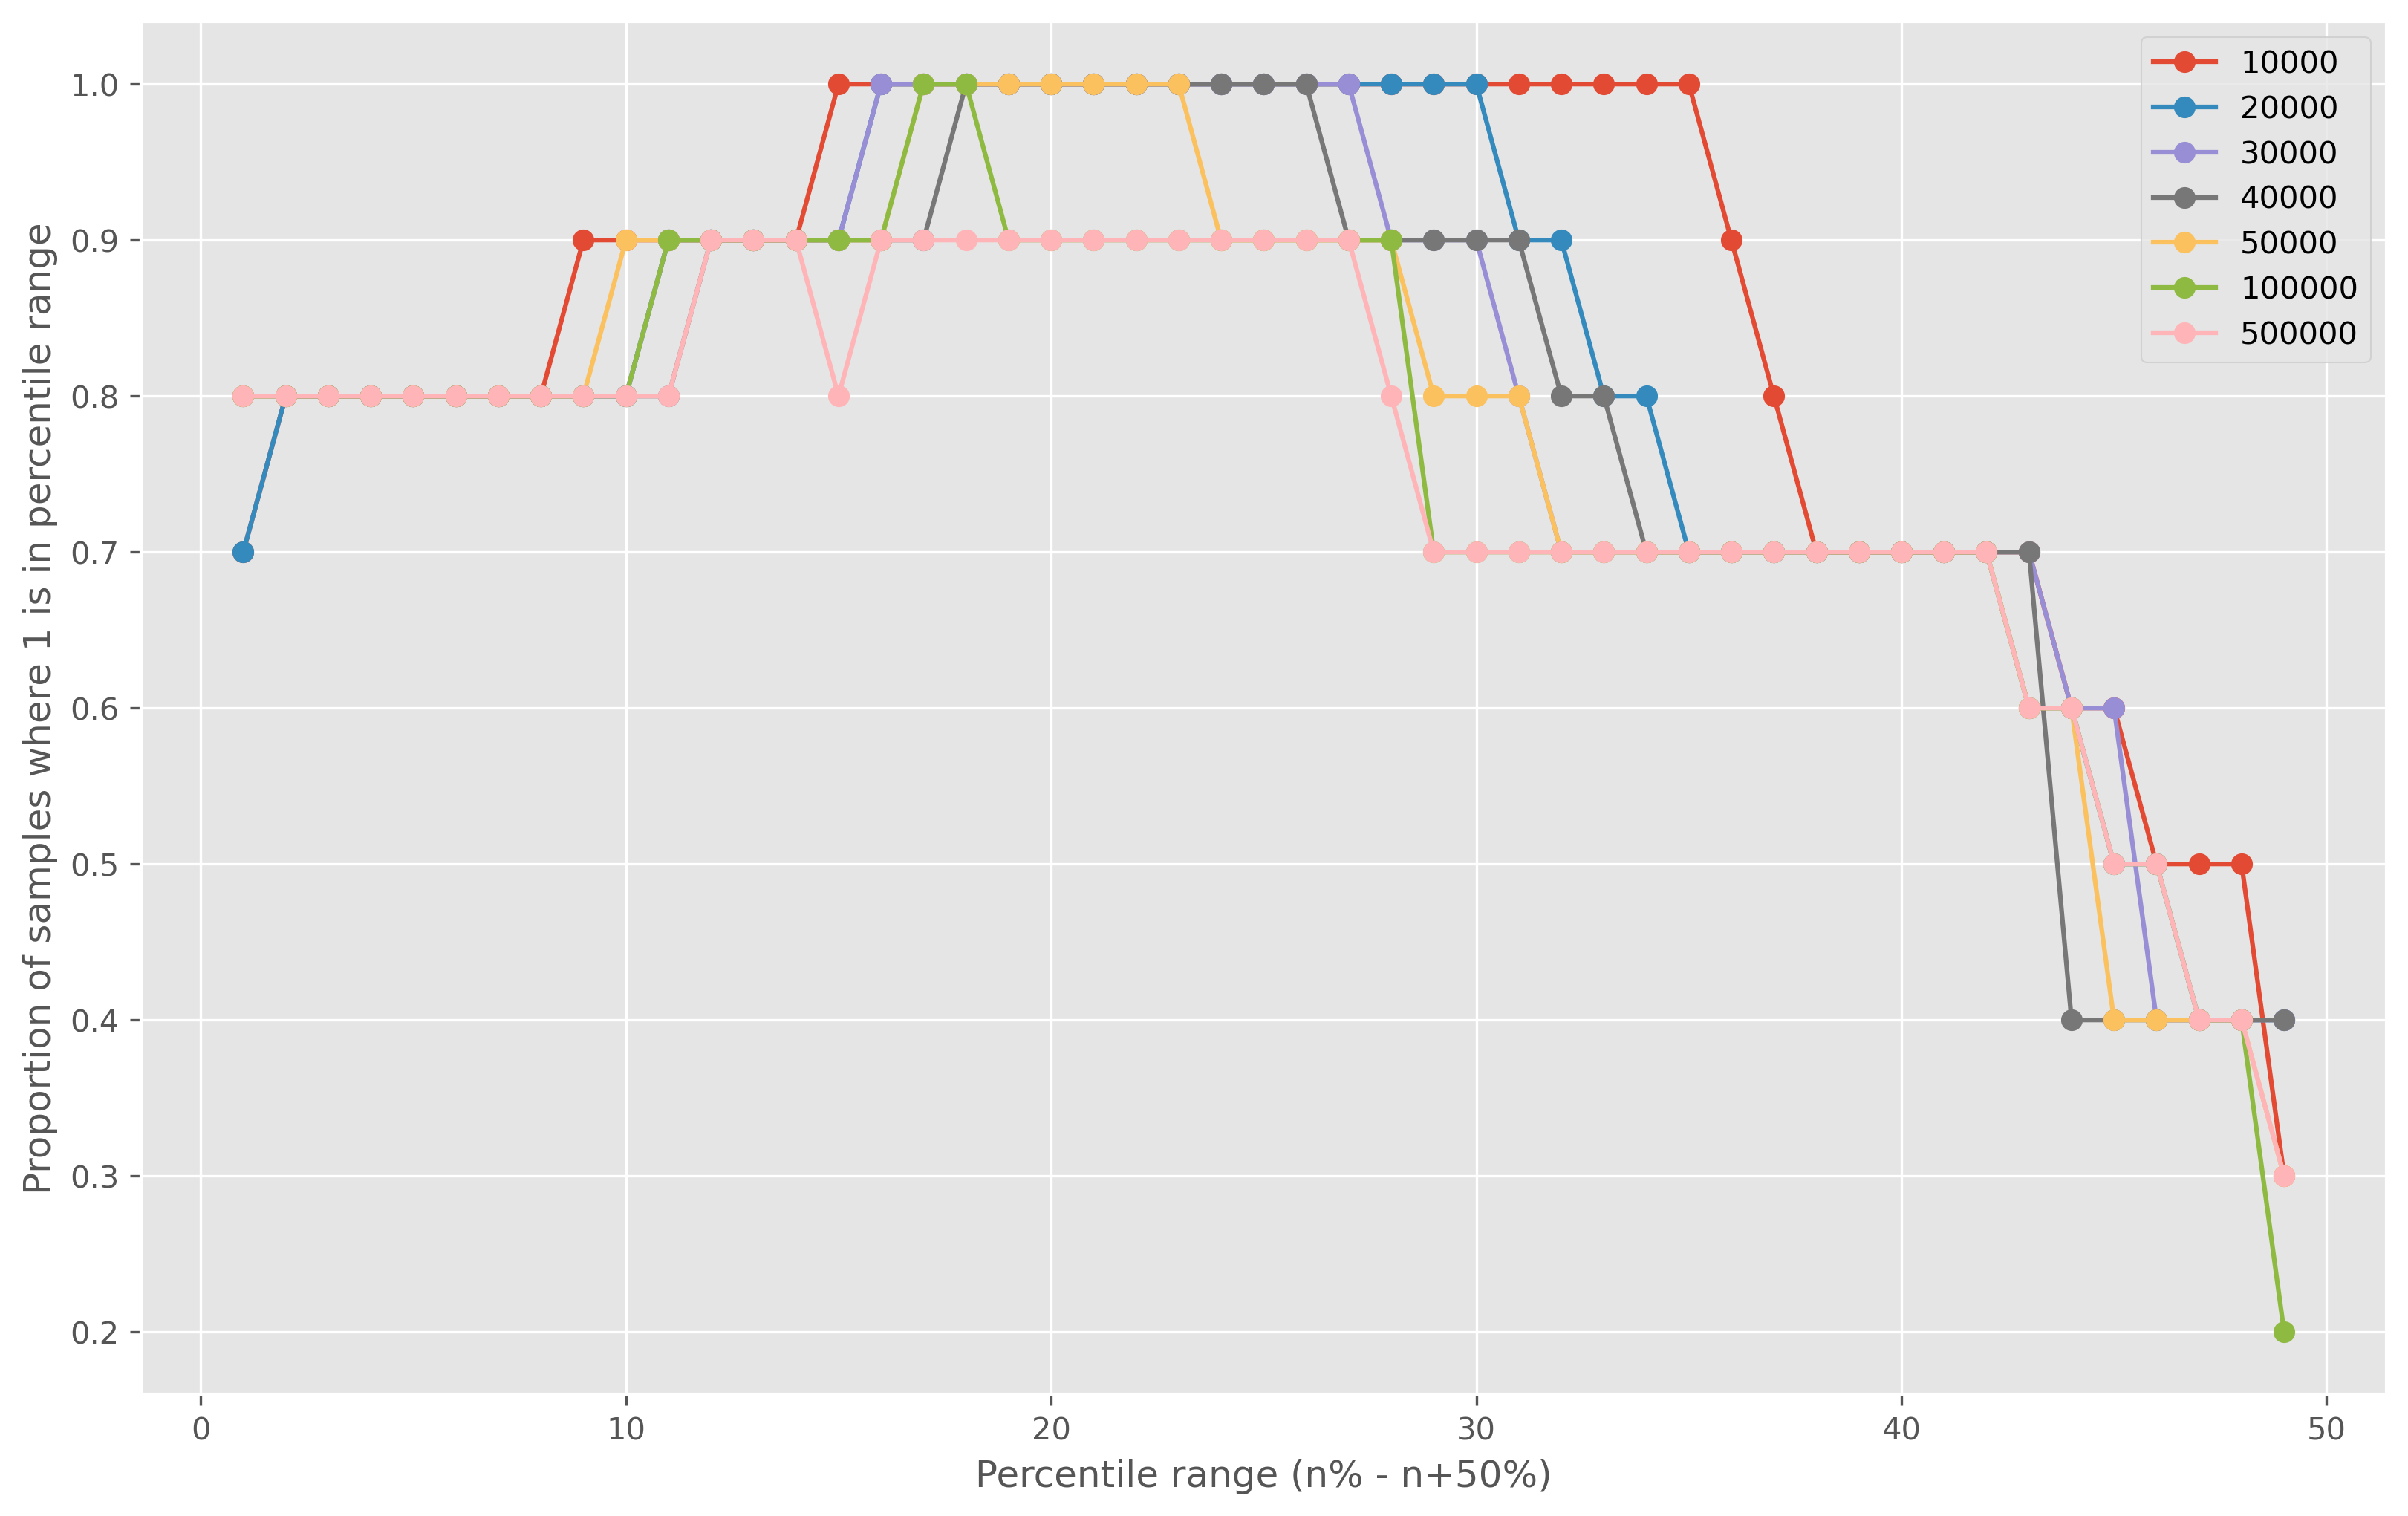

In [11]:
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["Q", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()
for q in d["Q"].unique():
    ax.plot("percentile_bin", "contains_one", data=d.query("Q == @q"), marker="o")

ax.legend(d["Q"].unique())
ax.set_xlabel("Percentile range (n% - n+50%)")
ax.set_ylabel("Proportion of samples where 1 is in percentile range")

[Text(0, 0.1, '0.1'),
 Text(0, 0.25, '0.25'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9, '0.9'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 3.0, '3'),
 Text(0, 4.0, '4'),
 Text(0, 5.0, '5')]

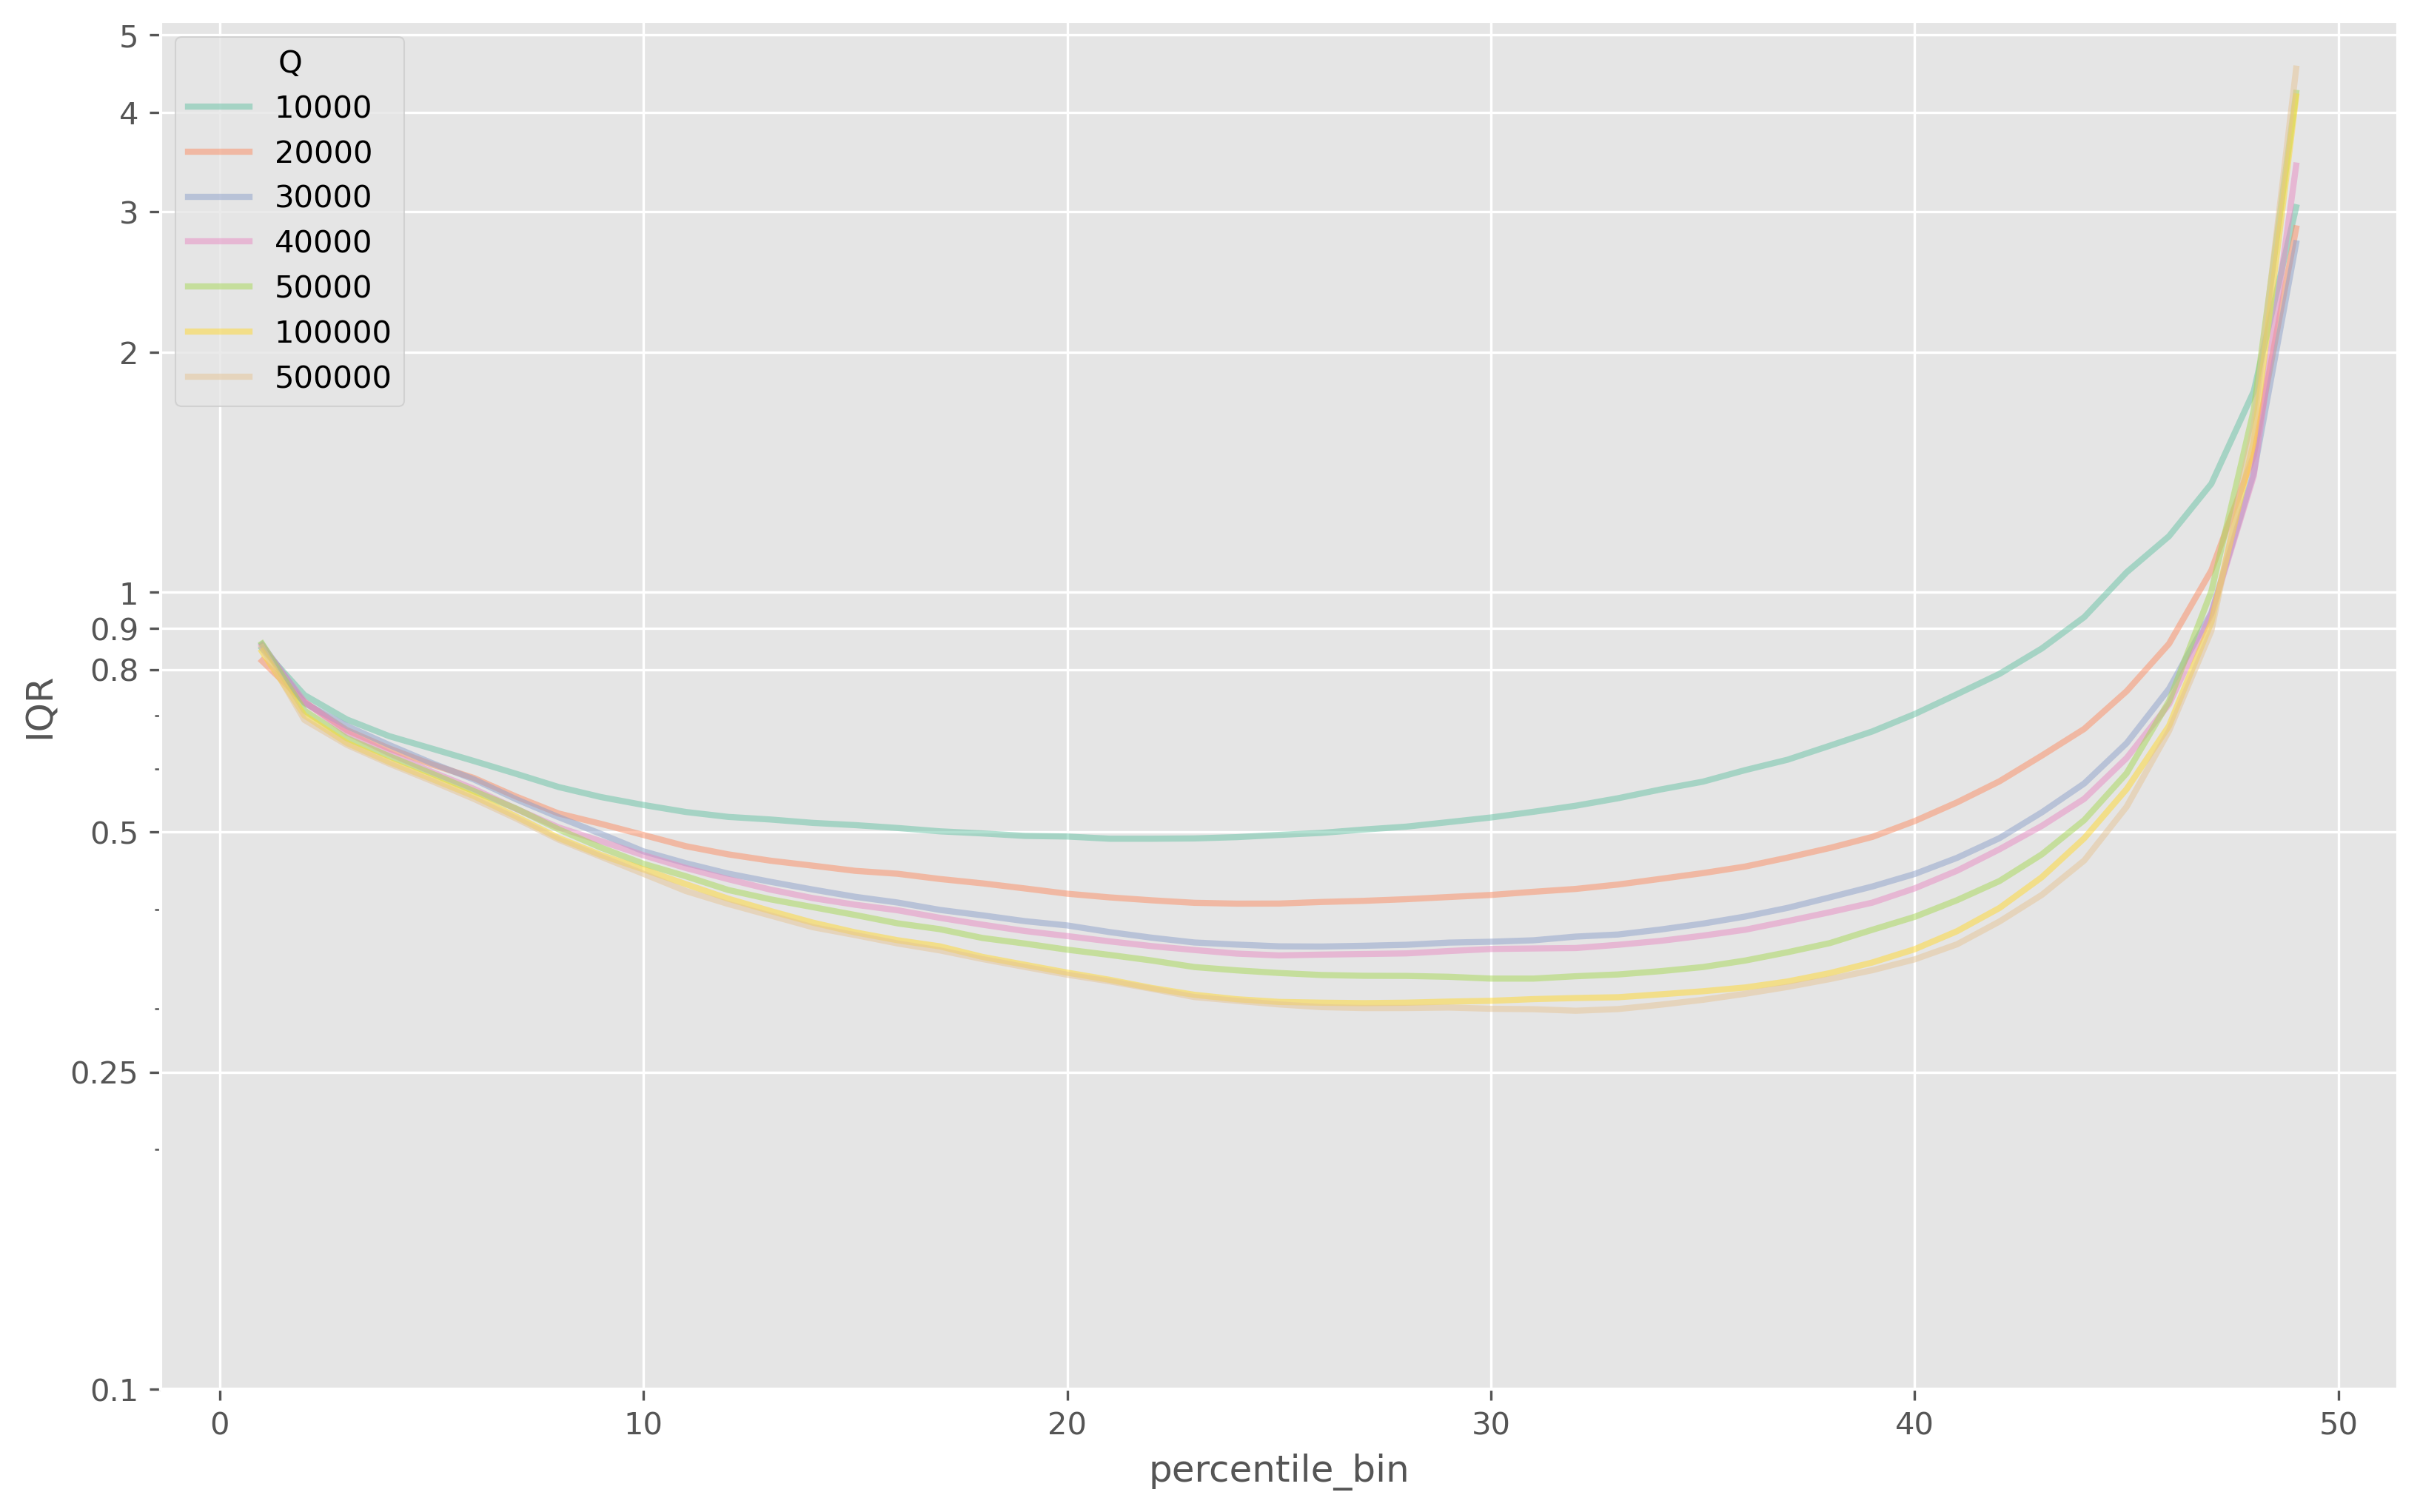

In [29]:
# plot how the IQR and contains_one change with the percentile range
fig, ax = plt.subplots(dpi=300)
d = rng_scan.groupby(["Q", "percentile_bin"])[["contains_one", "IQR"]].mean().reset_index()

sns.lineplot(data=d, x="percentile_bin", y="IQR", hue="Q", ax=ax, palette="Set2", linewidth=2, alpha=0.5)
ax.set_yscale("log")
yticks = [0.1, 0.25, 0.5, 0.8, 0.9, 1, 2, 3, 4, 5]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
